In [3]:
import pandas as pd
import numpy as np
import json
import pickle
import datetime as dt
import geopandas as gpd
from shapely.geometry import Point, LineString,MultiLineString,Polygon
from shapely import ops
import matplotlib.pyplot as plt
%matplotlib inline
import os
import folium
attr='(c) <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors (c) <a href="http://cartodb.com/attributions">CartoDB</a>, CartoDB <a href ="http://cartodb.com/attributions">attributions</a>'
from selenium import webdriver
import PIL
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import glob
import moviepy.editor as mpy
from flask import request

In [3]:
# Define the API endpoint
url = "https://data.traffic.hereapi.com/v7/flow"

# Define the query parameters
params = {
    "locationReferencing": "shape",
    #"in": "bbox:107.54908372065572,-6.926620456605005,107.72967148820469,-6.896286771555365",
    "in": "bbox:107.2510292754,-7.3097642655,107.9384321719,-6.8128449268",
    "apiKey": "z1hUE5rH83_F6uIgubqDkRHn6JQK8s5tUa106Nudp6c",
    "responseattributes": "sh,fc"
}


In [4]:
"https://traffic.api.here.com/traffic/6.3/flow.json?bbox=-6.926620456605005,107.54908372065572;-6.896286771555365,107.72967148820469&apiKey=Cdfx4rTgJqyfEJv1ydzReBDhwqpkx1PymIp4UjaYWvc&responseattributes=sh,fc"

'https://traffic.api.here.com/traffic/6.3/flow.json?bbox=-6.926620456605005,107.54908372065572;-6.896286771555365,107.72967148820469&apiKey=Cdfx4rTgJqyfEJv1ydzReBDhwqpkx1PymIp4UjaYWvc&responseattributes=sh,fc'

In [39]:
from shapely.geometry import Point, LineString
import geopandas as gpd

def dataframe (filename):
    with open(filename, 'r') as f:
        data = json.load(f)

    rows = []
    for result in data['results']:
        location = result['location']
        description = location['description']
        length = location['length']
        links = location['shape']['links']
        latitudes = []
        longitudes = []
        for link in links:
            if 'points' in link:
                for point in link['points']:
                    latitudes.append(point['lat'])
                    longitudes.append(point['lng'])
        speed = result['currentFlow']['speed']
        freeflow = result['currentFlow']['freeFlow']
        jamfactor = result['currentFlow']['jamFactor']
        rows.append([description, length, latitudes, longitudes, speed, freeflow, jamfactor])

    return (pd.DataFrame(rows, columns=['Description', 'Length', 'Latitudes', 'Longitudes', 'Speed', 'FreeFlow', 'JamFactor']))


In [5]:
df

,Description,Length,Latitudes,Longitudes,Speed,FreeFlow,JamFactor
0,Jalan Cibolerang,868.0,"[-6.946950014680624, -6.9475100096315145, -6.9...","[107.58877999149263, 107.58840003982186, 107.5...",6.666667,8.888889,1.4
1,Jalan Gede Bage Selatan/Jalan Ters Derwati,64.0,"[-6.965560019016266, -6.965620033442974, -6.96...","[107.68678002990782, 107.68678002990782, 107.6...",4.166667,5.000000,1.5
2,Jalan Cibolerang Barat,27.0,"[-6.952860010787845, -6.9528500363230705, -6.9...","[107.56370997056365, 107.5636300072074, 107.56...",5.000000,5.000000,0.0
3,Jalan Pusdai,975.0,"[-6.899220021441579, -6.899229995906353, -6.89...","[107.61841001920402, 107.61890002526343, 107.6...",7.222222,10.555556,3.0
4,Jalan Cihanjuang,583.0,"[-6.875810036435723, -6.875629993155599, -6.87...","[107.55955003201962, 107.55929002538323, 107.5...",5.833334,6.666667,0.0
...,...,...,...,...,...,...,...
2328,Jalan Gempol/Jalan Sukamaju,66.0,"[-6.926360037177801, -6.9263899605721235, -6.9...","[107.70531996153295, 107.70537997595966, 107.7...",4.444445,4.722222,0.5
2329,Jalan Pagarsih Barat,570.0,"[-6.918509965762496, -6.919389981776476, -6.91...","[107.5811399705708, 107.58100996725261, 107.58...",5.555556,5.555556,0.2
2330,Jalan Jend. Sudirman,356.0,"[-6.888469979166985, -6.888950010761619, -6.88...","[107.53704998642206, 107.53685996867716, 107.5...",7.222222,9.166667,1.2
2331,Jalan Jend. H. Amir Machmud/Jalan Raya Tagog,31.0,"[-6.876089992001653, -6.876089992001653, -6.87...","[107.54617997445166, 107.54611996002495, 107.5...",5.000000,6.666667,1.1


In [6]:
geometry = [LineString(list(zip(row['Longitudes'], row['Latitudes']))) for _, row in df.iterrows()]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.crs = {'init':'epsg:4326'}


In [7]:
gdf.head()

,Description,Length,Latitudes,Longitudes,Speed,FreeFlow,JamFactor,geometry
0,Jalan Cibolerang,868.0,"[-6.946950014680624, -6.9475100096315145, -6.9...","[107.58877999149263, 107.58840003982186, 107.5...",6.666667,8.888889,1.4,"LINESTRING (107.58878 -6.94695, 107.58840 -6.9..."
1,Jalan Gede Bage Selatan/Jalan Ters Derwati,64.0,"[-6.965560019016266, -6.965620033442974, -6.96...","[107.68678002990782, 107.68678002990782, 107.6...",4.166667,5.000000,1.5,"LINESTRING (107.68678 -6.96556, 107.68678 -6.9..."
2,Jalan Cibolerang Barat,27.0,"[-6.952860010787845, -6.9528500363230705, -6.9...","[107.56370997056365, 107.5636300072074, 107.56...",5.000000,5.000000,0.0,"LINESTRING (107.56371 -6.95286, 107.56363 -6.9..."
3,Jalan Pusdai,975.0,"[-6.899220021441579, -6.899229995906353, -6.89...","[107.61841001920402, 107.61890002526343, 107.6...",7.222222,10.555556,3.0,"LINESTRING (107.61841 -6.89922, 107.61890 -6.8..."
4,Jalan Cihanjuang,583.0,"[-6.875810036435723, -6.875629993155599, -6.87...","[107.55955003201962, 107.55929002538323, 107.5...",5.833334,6.666667,0.0,"LINESTRING (107.55955 -6.87581, 107.55929 -6.8..."


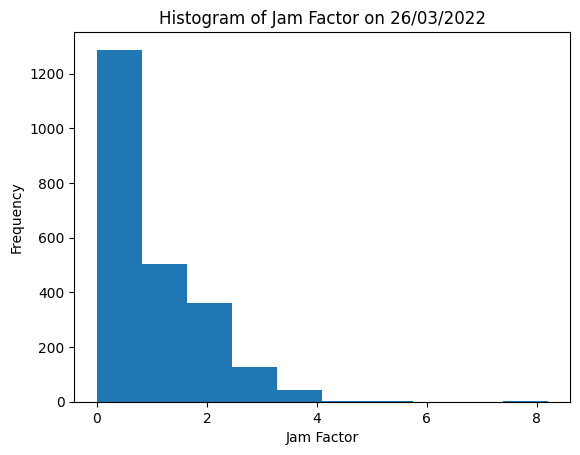

In [8]:
import matplotlib.pyplot as plt

# Create a histogram plot
plt.hist(df['JamFactor'], bins=10)

# Set the title and labels
plt.title('Histogram of Jam Factor on 26/03/2022')
plt.xlabel('Jam Factor')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [9]:
bin_edges = [-1, 1, 3, 4, 8, 11]

# use pd.cut to categorize the 'jamFactor' column
df['jamFactor_category'] = pd.cut(df['JamFactor'], bins=bin_edges)

df['group'] = df['jamFactor_category']
# print the count of observations in each category
print(df['group'].value_counts())

(-1, 1]    1412
(1, 3]      854
(3, 4]       58
(4, 8]        6
(8, 11]       3
Name: group, dtype: int64


<Axes: >

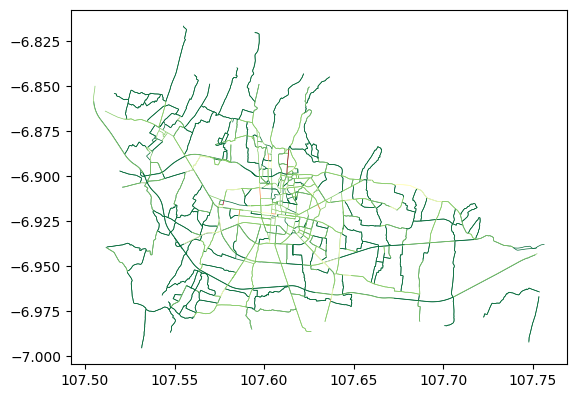

In [10]:
gdf.sort_values("JamFactor").plot(column="group", cmap='RdYlGn_r', categorical=True, linewidth=.5)

In [11]:
gdf['jamFactor_category']

0        (1, 3]
1        (1, 3]
2       (-1, 1]
3        (1, 3]
4       (-1, 1]
         ...   
2328    (-1, 1]
2329    (-1, 1]
2330     (1, 3]
2331     (1, 3]
2332    (-1, 1]
Name: jamFactor_category, Length: 2333, dtype: category
Categories (5, interval[int64, right]): [(-1, 1] < (1, 3] < (3, 4] < (4, 8] < (8, 11]]

In [47]:
#plot the lines on folium and save it as an HTML file:
import folium

def plot_lines_on_folium(gdf, fname, center_lat, center_lon, zoom_start):
    # convert JamFactor_category column to string
    gdf['jamFactor_category'] = gdf['jamFactor_category'].astype(str)
    
    # create map centered at specified latitude and longitude
    map_center = [center_lat, center_lon]
    m = folium.Map(location=map_center, zoom_start=zoom_start)

    # iterate over rows and add each line to the map with corresponding color
    for idx, row in gdf.iterrows():
        color = None
        if row['jamFactor_category'] == '(-1, 1]':
            color = 'green'
        elif row['jamFactor_category'] == '(1, 3]':
            color = 'yellow'
        elif row['jamFactor_category'] == '(3, 4]':
            color = 'orange'
        elif row['jamFactor_category'] == '(4, 8]':
            color = 'red'
        elif row['jamFactor_category'] == '(8, 11]':
            color = 'purple'

        if color:
            folium.PolyLine(locations=row['geometry'].coords, color=color).add_to(m)

    # save map as HTML file
    m.save(f'{fname}')
    

In [48]:
def process_here_maps_output (api_output_json):
    df = dataframe(api_output_json)
    geometry = [LineString(list(zip(row['Longitudes'], row['Latitudes']))) for _, row in df.iterrows()]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf.crs = {'init':'epsg:4326'} 
    bin_edges = [-1, 1, 3, 4, 8, 11]
    # use pd.cut to categorize the 'jamFactor' column
    df['jamFactor_category'] = pd.cut(df['JamFactor'], bins=bin_edges)
    df['group'] = df['jamFactor_category']
    html_filename = os.path.splitext(os.path.basename(api_output_json))[0] + '.html'
    plot_lines_on_folium(gdf, html_filename, -6.905977, 107.613144, 13)




In [68]:
import glob
import os

def process_here_maps_outputs(directory_path, output_dir):
    # Get a list of all JSON files in the directory
    json_files = glob.glob(os.path.join(directory_path, '*.json'))

    for json_file in json_files:
        # Process each JSON file using the existing logic
        try: 
            df = dataframe(json_file)
        except:
            print("An exception occurred") 
        geometry = [LineString(list(zip(row['Longitudes'], row['Latitudes']))) for _, row in df.iterrows()]
        gdf = gpd.GeoDataFrame(df, geometry=geometry)
        gdf.crs = {'init':'epsg:4326'} 
        bin_edges = [-1, 1, 3, 4, 8, 11]
        df['jamFactor_category'] = pd.cut(df['JamFactor'], bins=bin_edges)
        df['group'] = df['jamFactor_category']
        html_filename = os.path.splitext(os.path.basename(json_file))[0] + '.html'
        html_path = os.path.join(output_dir, html_filename)
        plot_lines_on_folium(gdf, html_path, -6.905977, 107.613144, 13)


In [69]:
process_here_maps_outputs('E:\FASTRACK\SMT 10\Bandung-Traffic', 'E:\FASTRACK\SMT 10\Bandung-Traffic\HTML')

An exception occurred
An exception occurred


In [70]:
import time

In [73]:
def sreenshot(html_file):
    base  = "E:\FASTRACK\SMT 10\Bandung-Traffic\HTML"
    delay=5
    browser = webdriver.Chrome()
    browser.get(html_file)

    time.sleep(delay)
    browser.save_screenshot("E:\FASTRACK\SMT 10\Bandung-Traffic\PNG"+html_file.replace("html","png"))
    browser.quit()

In [74]:
for f in os.listdir("E:\FASTRACK\SMT 10\Bandung-Traffic\HTML"):
    screenshot(f)

NameError: name 'screenshot' is not defined

In [52]:
all_data = {}
for i,f in enumerate(files):
    try:
        time1 = dt.datetime.strptime(f.split(".")[0], "%Y-%m-%d %H-%M-%S")
        fout = str(time1).replace(":","-")+".html"
        if fout not in outs:
            tes = process_here_maps_output(f)
            all_data[f] = tes['JF']
        else:
            continue
        print ("\r",str(i)),
    except:
        print ("\r","failed ",str(i))

 failed  0
 failed  1
 failed  2
 failed  3
 failed  4
 failed  5
 failed  6
 failed  7
 failed  8
 failed  9
 failed  10
 failed  11
 failed  12
 failed  13
 failed  14
 failed  15
 failed  16
 failed  17
 failed  18
 failed  19
 failed  20
 failed  21
 failed  22
 failed  23
 failed  24
 failed  25


In [30]:
def process_here_maps_output_(api_output_json):
    with open(api_output_json, 'r') as f:
        data = json.load(f)

    # Load API output JSON as a pandas dataframe
    rows = []
    for result in data['results']:
        location = result['location']
        description = location['description']
        length = location['length']
        links = location['shape']['links']
        latitudes = []
        longitudes = []
        for link in links:
            if 'points' in link:
                for point in link['points']:
                    latitudes.append(point['lat'])
                    longitudes.append(point['lng'])
        speed = result['currentFlow']['speed']
        freeflow = result['currentFlow']['freeFlow']
        jamfactor = result['currentFlow']['jamFactor']
        rows.append([description, length, latitudes, longitudes, speed, freeflow, jamfactor])

    df = pd.DataFrame(rows, columns=['Description', 'Length', 'Latitudes', 'Longitudes', 'Speed', 'FreeFlow', 'JamFactor'])
    
    # Create a geopandas dataframe from the extracted information
    gdf = gpd.GeoDataFrame(pd.DataFrame(rows, columns=['Description', 'Length', 'Latitudes', 'Longitudes', 'Speed', 'FreeFlow', 'JamFactor']))
    gdf['geometry'] = gdf.apply(lambda row: LineString([(x, y) for x, y in zip(row.Longitudes, row.Latitudes)]), axis=1)

    #gdf['geometry'] = gdf.apply(lambda row: LineString(list(zip(row.Longitudes, row.Latitudes))), axis=1)
    gdf.crs = {'init':'epsg:4326'}
    
    # Categorize the JamFactor column and add it to the dataframe
    bin_edges = [-1, 1, 3, 4, 8, 11]
    gdf['JamFactor_category'] = pd.cut(gdf['JamFactor'], bins=bin_edges, labels=['<=1', '1-3', '3-4', '4-8', '>8'])
    
    # Plot the map based on JamFactor category
    m = folium.Map(location=[gdf['Latitudes'].mean(), gdf['Longitudes'].mean()], zoom_start=12)
    for _, row in gdf.iterrows():
        folium.PolyLine(locations=row.geometry.coords, color=row.JamFactor_category, opacity=0.8).add_to(m)
    
    # Save the folium map as an HTML file
    html_filename = os.path.splitext(os.path.basename(api_output_json))[0] + '.html'
    m.save(html_filename)
    
    return df, gdf, m
